#### High Performance and Disruptive Computing in Remote Sensing School 2025 2025
# Hands-on with Qiskit: Hello World - Qiskit Patterns

In this notebook you will walk through a Qiskit Patterns workflow, and use Qiskit's two  [primitives](https://docs.quantum.ibm.com/guides/get-started-with-primitives): the `Sampler` and the `Estimator`.

This tutorial partially involves content from [IBM Quantum Documentation: Hello World](https://docs.quantum.ibm.com/guides/hello-world).

## Create and run a simple quantum program using the Qiskit pattern framework


The four steps to writing a quantum program using Qiskit patterns are:

1.  Map the problem to a quantum-native format.

2.  Optimize the circuits and operators.

3.  Execute using a Qiskit primitive function. 

4.  Analyze the results.

First we will make the necessary imports:

In [24]:
from qiskit import QuantumCircuit
import qiskit_ibm_runtime
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

### Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) object, then add instructions to it in sequence.


The following code cell creates a circuit that produces a *Bell state,* which is a state wherein two qubits are fully entangled with each other.

<div class="alert alert-success">

**Step 1** Create a circuit for the Bell state $\frac{|00\rangle + |11\rangle}{\sqrt{2}}$

</div>


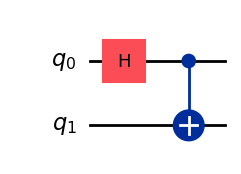

In [25]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl") 

#options to save the circuit figure 
#qc.draw('mpl').savefig(‘name.png’, dpi=300)
#qc.draw('mpl').savefig(‘name.svg’)

When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain the expectation value of an observable, or you can obtain a probability distribution for a set of qubits you choose to measure. Prepare your workload to measure your circuit in one of these two ways with [Qiskit primitives](https://docs.quantum.ibm.com/guides/get-started-with-primitives).


- `Estimator` primitive - returns the expectation value of an observable
- `Sampler` primitive - returns a probability distribution for a set of qubits you choose to measure

<div class="alert alert-success">

**Step 1b - Estimator Primitive** Define the observables for which you want to calculate the expectation values

</div>

This example measures expectation values by using the `qiskit.quantum_info` submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: `IZ`, `IX`, `ZI`, `XI`, `ZZ`, and `XX`.

As the Bell state is a maximally entangled state, we expect to see see non-zero expectation values for  `ZZ`, and `XX` -- indeed we expect an expectation value of 1 for this particular state for both of these observables. And an expectation value of 0 for `IZ`, `IX`, `ZI`, `XI`. 

This is a signature of entanglement, as neither qubit has definite individual properties. Measuring either qubit alone gives completely random results (+1 or -1 with equal probability).

In [26]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels] # list of observables

<div class="alert alert-success">

**Step 1b - Sampler Primitive** Make a note to add measurement gates to the circuit

</div>

The `Sampler` samples the circuit and returns a probability distribution of measurement outcomes. This means we will need to add measurement gates to the circuit. 

Since the `Estimator` returns expectation values of observables, measurement gates would interfere with its functionality. Hence we will introduce measurement gates for the `Sampler` once we're done processing the circuit for `Estimator`.

### Step 2. Optimize the circuits for the target hardware

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/guides/transpile#instruction-set-architecture) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a simulator to submit a job to and transforms the circuit and observables to match that backend's ISA. Note that we will use a real device later.

In [27]:
backend = FakeAlmadenV2()

In [28]:
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
    f"Native gate set: {backend.operation_names}\n"
)

#to view other properties you can use properties()
# refer to https://docs.quantum.ibm.com/guides/get-qpu-information
#backend.properties().to_dict()
#backend.properties().qubit_property(0)

#### Exercise: fetch and compare properties of other simulators FakeValenciaV2, FakeTorino, FakeBrisbane. Don't forget to import them.

Name: fake_almaden
Version: 2
No. of qubits: 20
Native gate set: ['cx', 'reset', 'measure', 'delay', 'u1', 'u3', 'u2', 'id']



<div class="alert alert-success">

**Step 2 - Estimator Primitive** Transpile the circuit into ISA circuit (ISA = Instruction Set Architecture)

</div>

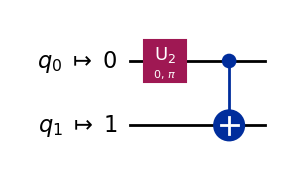

In [29]:
estimator = Estimator(backend) # creates an estimator using the selected backend

# Convert to an ISA circuit 
 
pm_estimator = generate_preset_pass_manager(backend=backend, optimization_level=1) # generates the pass manager, which is a list of transpiler passes grouped into a logical unit

isa_circuit_estimator = pm_estimator.run(qc) # runs the pass manager to create the ISA circuit 

isa_circuit_estimator.draw("mpl", idle_wires=False) # draws the circuit, note: idle_wires = False to hide all the qubits not being used

#### Exercise: Compare this with the ISA circuits for other backends and note the differences

<div class="alert alert-success">

**Step 2 - Sampler Primitive** Transpile the circuit into ISA circuit (ISA = Instruction Set Architecture)

</div>

But first add measurement gates to the circuit!

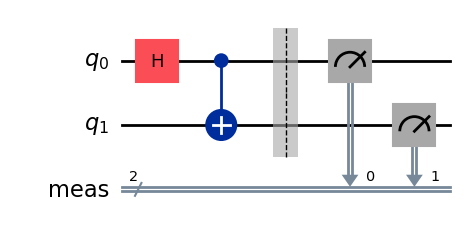

In [30]:
qc.measure_all() # adds a barrier, applies measurement gates on all qubits, creates a classical register called `meas`
qc.draw('mpl')

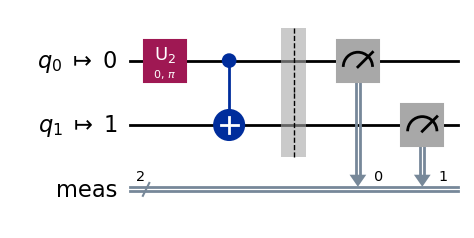

In [31]:
sampler = Sampler(backend) # creates a sampler using the selected backend

# Convert to an ISA circuit
pm_sampler = generate_preset_pass_manager(backend=backend, optimization_level=1) 

isa_circuit_sampler = pm_sampler.run(qc) 


isa_circuit_sampler.draw("mpl", idle_wires=False) 

### Step 3. Execute using the Qiskit primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the `Estimator` class. `Sampler` can be used to get data from a quantum computer.  These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using a [primitive unified bloc (PUB).](https://docs.quantum.ibm.com/guides/primitive-input-output#pubs)



<div class="alert alert-success">

**Step 3 - Estimator Primitive** Submit a job using the Estimator primitive.

</div>

In [32]:
# Create layout-mapped observables for the ISA circuit

mapped_observables = [
    observable.apply_layout(isa_circuit_estimator.layout) for observable in observables
]

job_estimator = estimator.run([(isa_circuit_estimator, mapped_observables)])
 
# Result of the entire primitive execution. (You submitted one PUB, so this contains one inner result, and some metadata of its own.):

job_estimator_result = job_estimator.result()
 
# Result from your single PUB, which had five observables, so contains information on all five:
 
pub_result_estimator = job_estimator.result()[0]


<div class="alert alert-success">

**Step 3 - Sampler Primitive** Submit a job using the Sampler primitive.

</div>

In [33]:
job_sampler = sampler.run([isa_circuit_sampler], shots=1024) # runs the sampler primitive on ISA circuit for specified number of shots

result_sampler = job_sampler.result() # saves the result of the job 

### Step 4. Post-process the results

This step involves postprocessing your results. You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem.  

- For the `Estimator`, we plot the values of the expecation values of the observables using `pyplot`
- For the `Sampler`, we plot the probability distribution obtained by sampling the quantum circuit as many times as the shots you specified using `plot_histogram`.

<div class="alert alert-success">

**Step 4 - Estimator Primitive** Visualize the results using `pyplot`

</div>

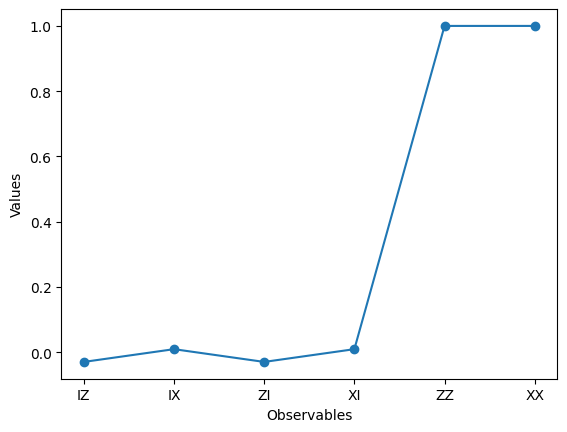

In [40]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result_estimator.data.evs

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

<div class="alert alert-success">

**Step 4 - Sampler Primitive** Visualize the results using `plot_histogram`

</div>

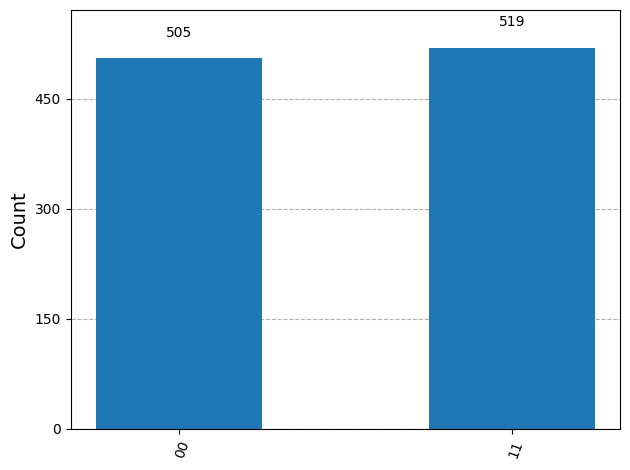

In [35]:
from qiskit.visualization import plot_histogram

counts = result_sampler[0].data.meas.get_counts() # meas is the default name of the classical register when using measure_all(). If you specify a classical register, then use the name you assign

# Plot the result
plot_histogram(counts)

# Running on a Real Device

You can access real devices through your account on the [IBM Quantum Platform](https://quantum.ibm.com/). 

(Please note that the IBM Quantum Platform is moving to quantum.cloud.ibm.com and this version will be sunset on July 1. To get started on the new platform, read the [migration guide](https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp).)

We used a simulator for this example. If you'd like to run this code on a real device, you can use the following code. This uses the `Sampler` primitive.

In order to run the `Estimator` primitive on a real device, refer to the code given in [IBM Quantum Documentation: Hello World](https://docs.quantum.ibm.com/guides/hello-world). Remember to create a new circuit without measurement gates.

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [ ]:
# If you have not previously saved your credentials, follow instructions at https://docs.quantum.ibm.com/guides/setup-channel#iqp
# to authenticate with your API token.

your_token = "insert your token here"

QiskitRuntimeService.save_account(
  token=your_token,
  channel="ibm_quantum", 
  overwrite=True
)

In [ ]:
# If you are using quantum.cloud.ibm.com instead of quantum.ibm.com then use the following code instead

#your_token = "insert your token here"
#your_instance = "insert your instance here"

'''
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_token,
    instance=your_instance,
    set_as_default=True,
    overwrite=True,
)
'''


In [ ]:
# view the list of backends you have access to

service = QiskitRuntimeService()

service.backends()

In [ ]:
# Get backend
backend_real = service.least_busy(simulator=False, operational=True)

#backend_real = service.backend(name="insert_backend_name") # use this if you want to choose a specific backend 

sampler = Sampler(backend_real)

pm = generate_preset_pass_manager(backend=backend_real, optimization_level=3)
isa_circuit = pm.run(qc) 

job = sampler.run([isa_circuit], shots=1024)
result = job.result()

In [ ]:
print(job.job_id)

In [16]:
print(
    f"Name: {backend_real.name}\n"
    f"Version: {backend_real.version}\n"
    f"No. of qubits: {backend_real.num_qubits}\n"
    f"Native gate set: {backend_real.operation_names}\n"
)

Name: alt_marrakesh
Version: 2
No. of qubits: 156
Native gate set: ['reset', 'delay', 'cz', 'sx', 'x', 'if_else', 'measure', 'for_loop', 'switch_case', 'xslow', 'id', 'rz']



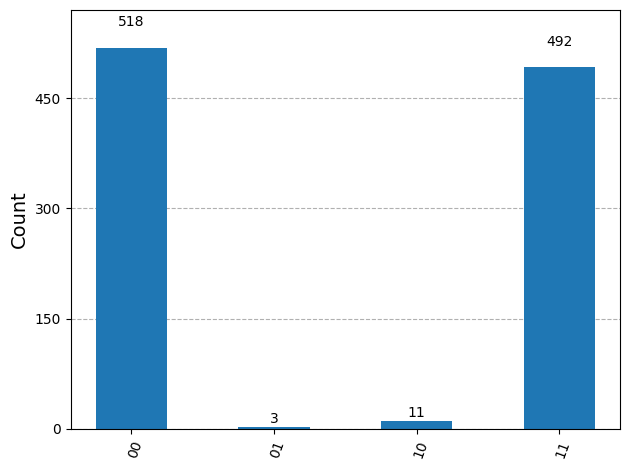

In [17]:
counts = result[0].data.meas.get_counts() # meas is the default name of the classical register when using measure_all(). If you specify a classical register, then use the name you assign

plot_histogram(counts)